# General Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pyCascade import probePost, physics, quantities
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit

category =  "config1"



In [2]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

# Run

In [3]:
run = 2
qois = ['comp(u,0)', 'comp(u,2)']

In [4]:
probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut', file_type = 'parquet')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')

In [5]:
stack = [1, 10, 20, 30, 40, 50, 100, 150]

start = -250000
stop = -1000
by = 1

## Spectra

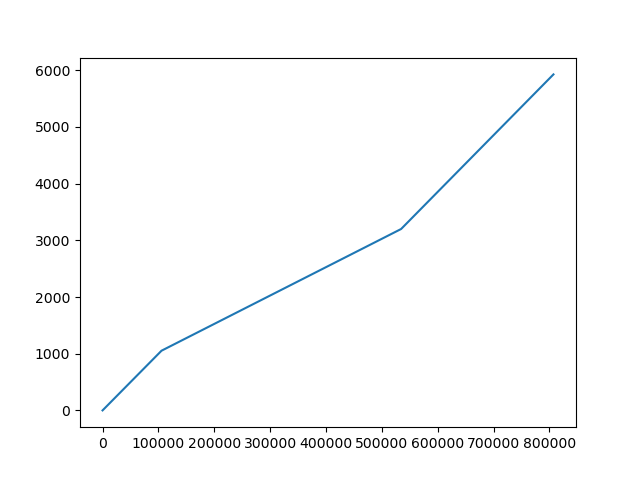

In [6]:
plt.plot(probes.probe_steps, probes.probe_times)

In [7]:
qty_dict = probes.create_qty_dict(
    names = ["col_9-6"],#[name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    stack = stack,
)


processing data took 26 seconds


/home/users/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:266: RuntimeWarning: divide by zero encountered in power
  ax.loglog(qty.f, initial_offset*qty.f**(eval(scaling)), label = scaling)


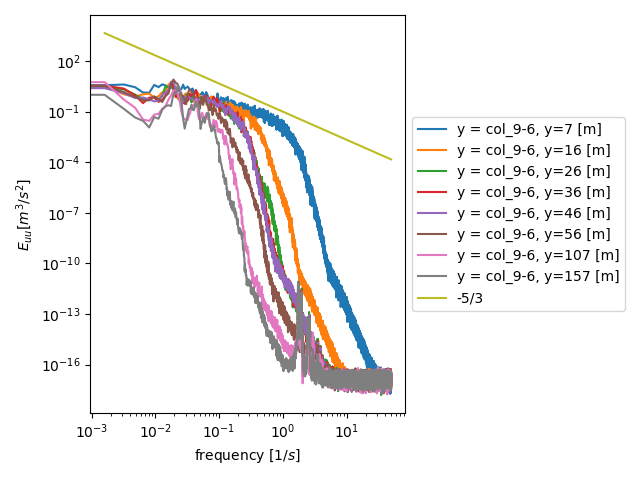

In [8]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = 'Euu')

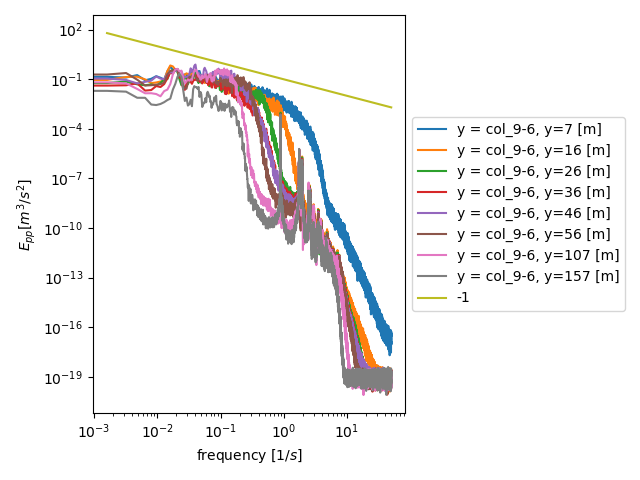

In [14]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = "Epp", scaling = "-1")

## Plot ABL

In [13]:
qty_dict = probes.create_qty_dict(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    stack = stack,
)


processing data took 53 seconds
processing data took 52 seconds


KeyboardInterrupt: 

In [ ]:
qty_dict = probes.create_qty_dict(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    stack = range(1:60),
)

In [ ]:
quantities.plot_ABL(qty_dict, fit_disp=True)

## Plot Length Scales

In [ ]:
quantities.plot_length_scales(qty_dict)

## Plot Reynolds stresses

In [ ]:
quantities.plot_reynolds_stresses(qty_dict)

## Plot Turbulence Intensities

In [ ]:
quantities.plot_turbulence_intensities(qty_dict)

## Plot prms

In [ ]:
quantities.plot_prms(qty_dict)